In [2]:
import fcsfiles as fcs # Small one-man repo, likely has bugs
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [19]:
def get_corr(files, clip=False, dir="../data/2024_09_05-FCSandImg/", all_corr=False):
    '''
    Function to extract correlation from a list of fcs files. 
    Returns times, average of all correlations, and number of traces used (usually more than one per file).
    '''
    if type(files) != list:
        files = [files]
    n_total = 0
    for f in files:
        data = fcs.ConfoCor3Fcs(f'{dir}{f}')
        n_samp = len(data['FcsData']['FcsEntry'])
        n_total += n_samp
        for i in range(n_samp):
            if i==0 and n_total==n_samp: # This should only happen once.
                times_corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,0]
                sum_corr = np.zeros(len(times_corr))
            corr = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
            if clip:
                corr = corr - corr[clip] + 1
            if len(corr) == 0: # This had to be added because of extra entry in atto488. Probably the average done in ZEN. 
                n_total -= 1
                continue
            sum_corr += corr
    mean_corr = sum_corr/n_total
    return times_corr, mean_corr, n_total

In [4]:
def get_countrate(files, dir="../data/2024_09_05-FCSandImg/"):
    '''
    Function to extract average count rate. Equivelent to relative intesntiy or brightness of the signal.
    Returns the avergae of all traces of all files provided. Uses only the first ~1/5 of the trace. 
    '''
    all_counts = []
    if type(files) != list:
        files = [files]
    for f in files:
        data = fcs.ConfoCor3Fcs(f'{dir}{f}')
        n_samp = len(data['FcsData']['FcsEntry'])
        for i in range(n_samp):
            counts = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CountRateArray'][:,1]
            all_counts.append(np.mean(counts[0:152])) # This should be the first 1 sec of a 5 sec trace. For atto488 it would be first 2 sec...
    return np.mean(all_counts)

In [5]:
def f_includeK(tau, N, tauD, k):
    return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5
def f_standard(tau, N, tauD):
    k = 4.2 # measured below from atto488 control
    return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5
def f_anomalous(tau, N, tauD):
    k = 4.2
    alpha = 0.7
    return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(k**2)))**0.5
def f_alpha0p8(tau, N, tauD):
    k = 4.2
    alpha = 0.8
    return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(k**2)))**0.5

/tmp/ipykernel_53829/334216838.py:2: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


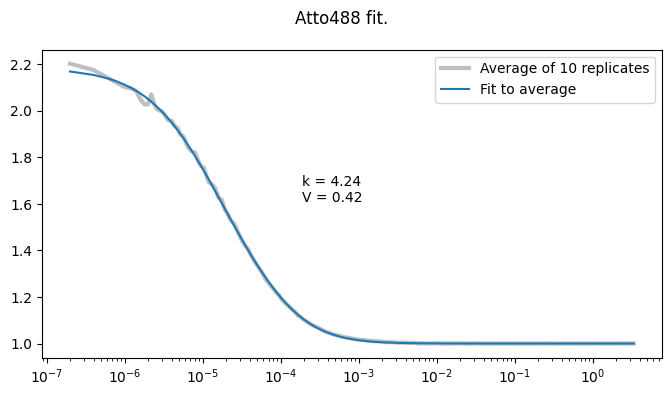

In [20]:
# Calibrate size of focal volume using concentration of atto488
atto2nM = 'atto488_2nM_blocked.fcs'
times_corr, mean_corr, n_total = get_corr(atto2nM, dir="../data/2024_09_10-NiceImgs/")
fit = curve_fit(f_includeK, times_corr, mean_corr, p0=None)
popt, pcov = fit
title = f"Atto488 fit."
fig, axs = plt.subplots(1, 1, figsize=(8,4))
fig.suptitle(title)
axs.set_xscale("log")
axs.plot(times_corr, mean_corr, linewidth=3, alpha=0.5, color="grey", label=f"Average of {n_total} replicates")
axs.plot(times_corr, f_includeK(times_corr, *popt), 
         label="Fit to average")
axs.legend()
fig.text(.45,.5,s=f"k = {round(popt[2],2)} \nV = {round(popt[0]/2,2)}")
V = 0.42

In [21]:
files = ["Ap5_1nuc_unpolarized.fcs", "Ap5_moreYeast.fcs"]
times_corr, mean_corr, n_total = get_corr(files, clip=140)
popt, pcov = curve_fit(f_anomalous, times_corr, mean_corr, bounds=(0,100))
counts = get_countrate(files)
N = popt[0]
C = N/V
print(C, counts)
print(f"{C/counts} is factor for C per counts")

22.359382371694362 109877.55847953216
0.00020349362218363668 is factor for C per counts


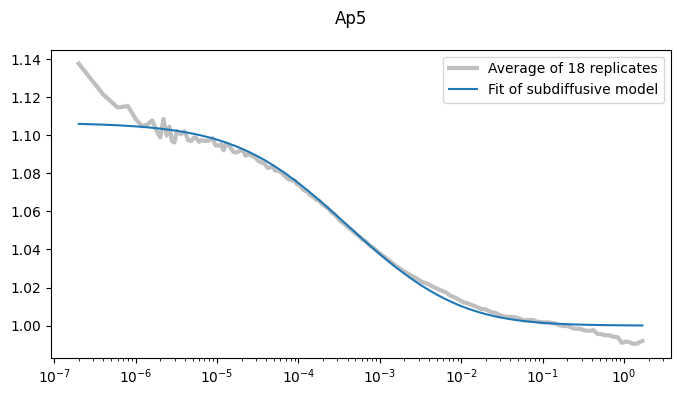

In [22]:
title = "Ap5"
fig, axs = plt.subplots(1, 1, figsize=(8,4))
fig.suptitle(title)
axs.set_xscale("log")
axs.plot(times_corr, mean_corr, linewidth=3, alpha=0.5, color="grey", label=f"Average of {n_total} replicates")
axs.plot(times_corr, f_anomalous(times_corr, *popt), 
         label=f"Fit of subdiffusive model")
axs.legend()

In [23]:
# Find ideal subdiffusivity parameter, alpha. 
Ap4 = ["Ap4_1nuc_unpolarized.fcs", "Ap4_1nuc_polarized.fcs"]
Ap5 = ["Ap5_1nuc_unpolarized.fcs", "Ap5_moreYeast.fcs"]
Ap6 = ["Ap6_yeast.fcs", "Ap6_polarizedYeast.fcs"]

Ap4a = "Ap4_1nuc_unpolarized.fcs"
Ap4b = "Ap4_1nuc_polarized.fcs"
Ap5a = "Ap5_1nuc_unpolarized.fcs"
Ap5b = "Ap5_moreYeast.fcs"
Ap6a = "Ap6_yeast.fcs"
Ap6b = "Ap6_polarizedYeast.fcs"

Sc2 = "Sc2_unbudded.fcs" #Cdc24
Sc3 = "Sc3_unbudded.fcs" #Bem1
Sc4 = "Sc4_unbudded.fcs" #Ste20
Sc5 = "Sc5_unbudded.fcs" #Cla4

all_probes = (Ap4a, Ap4b, Ap5a, Ap5b, Ap6a, Ap6b, Sc2, Sc3, Sc4, Sc5)
ap_best = (Ap4a, Ap4b, Ap5a, Ap5b) # Ap6: ApBem1-GFP is excluded because its FCS curves look pretty bad and its apparent concentration too high for FCS. 
sc_probes = (Sc2, Sc3, Sc4, Sc5) # Sc experiments generally had worse photobleaching and FCS fits. 

# allow alpha parameter to be fit
def f_anomalous(tau, N, tauD, alpha):
    k = 4.2
    return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(k**2)))**0.5

for probe in all_probes:
    times_corr, mean_corr, n_total = get_corr(probe, clip=135)
    popt, pcov = curve_fit(f_anomalous, times_corr[10:135], mean_corr[10:135], bounds=([0,0,0.4],[100,100,1]))
    counts = get_countrate(probe)
    err = np.sum((mean_corr[10:135] - f_anomalous(times_corr[10:135], *popt))**2)
    N = popt[0]
    C = N/V
    #print(f"{probe} \t counts = {5000/counts} \t conc per count = {C*5000/counts} \n")
    print(probe.split("_")[0], ":\t alpha =", round(popt[2],3), "\t fit error =", round(err*1000,2))
    #alphas.append(alpha)
print("--- good Ap FCS traces only ---")
alphas = []
for probe in ap_best:
    times_corr, mean_corr, n_total = get_corr(probe, clip=135)
    popt, pcov = curve_fit(f_anomalous, times_corr[10:135], mean_corr[10:135], bounds=([0,0,0.4],[100,100,1]))
    counts = get_countrate(probe)
    err = np.sum((mean_corr[10:135] - f_anomalous(times_corr[10:135], *popt))**2)
    N = popt[0]
    C = N/V
    #print(f"{probe} \t counts = {5000/counts} \t conc per count = {C*5000/counts} \n")
    print(probe.split("_")[0], ":\t alpha =", round(popt[2],3), "\t error =", round(err*1000,2))
    alphas.append(popt[2])
print(f"best average alpha for Ap: {np.mean(alphas)}")
print("--- Sc FCS traces only ---")
alphas = []
for probe in sc_probes:
    times_corr, mean_corr, n_total = get_corr(probe, clip=135)
    popt, pcov = curve_fit(f_anomalous, times_corr[10:135], mean_corr[10:135], bounds=([0,0,0.4],[100,100,1]))
    counts = get_countrate(probe)
    err = np.sum((mean_corr[10:135] - f_anomalous(times_corr[10:135], *popt))**2)
    N = popt[0]
    C = N/V
    #print(f"{probe} \t counts = {5000/counts} \t conc per count = {C*5000/counts} \n")
    print(probe.split("_")[0], ":\t alpha =", round(popt[2],3), "\t error =", round(err*1000,2))
    alphas.append(popt[2])
print(f"best average alpha for Sc: {np.mean(alphas)}")

Ap4 :	 alpha = 0.687 	 fit error = 0.04
Ap4 :	 alpha = 0.674 	 fit error = 0.04
Ap5 :	 alpha = 0.674 	 fit error = 0.35
Ap5 :	 alpha = 0.673 	 fit error = 0.2
Ap6 :	 alpha = 0.587 	 fit error = 0.02
Ap6 :	 alpha = 0.673 	 fit error = 0.02
Sc2 :	 alpha = 0.761 	 fit error = 1.39
Sc3 :	 alpha = 0.641 	 fit error = 3.06
Sc4 :	 alpha = 0.818 	 fit error = 1.0
Sc5 :	 alpha = 0.7 	 fit error = 1.46
--- good Ap FCS traces only ---
Ap4 :	 alpha = 0.687 	 error = 0.04
Ap4 :	 alpha = 0.674 	 error = 0.04
Ap5 :	 alpha = 0.674 	 error = 0.35
Ap5 :	 alpha = 0.673 	 error = 0.2
best average alpha for Ap: 0.6771596411252975
--- Sc FCS traces only ---
Sc2 :	 alpha = 0.761 	 error = 1.39
Sc3 :	 alpha = 0.641 	 error = 3.06
Sc4 :	 alpha = 0.818 	 error = 1.0
Sc5 :	 alpha = 0.7 	 error = 1.46
best average alpha for Sc: 0.7297733047474042


In [25]:
def f_anomalous_Ap(tau, N, tauD):
    k = 4.2
    alpha = 0.68
    return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(k**2)))**0.5
# Green probes 
for probe in [Ap4, Ap5]:
    times_corr, mean_corr, n_total = get_corr(probe, clip=135)
    popt, pcov = curve_fit(f_anomalous, times_corr[10:135], mean_corr[10:135], bounds=(0,100))
    counts = get_countrate(probe)
    N = popt[0]
    C = N/V
    print(f"{probe[0][:3]} : {round(C, 3)} nM")

Ap4 : 108.018 nM
Ap5 : 48.222 nM


In [233]:
# Red probes
Ap12 = "Ap12_yeast.fcs"
rac1 = "ApRac1_yeast.fcs"
for probe in [Ap12, rac1]:
    times_corr, mean_corr, n_total = get_corr(probe, clip=135)
    popt, pcov = curve_fit(f_anomalous, times_corr[10:135], mean_corr[10:135], bounds=(0,100))
    counts = get_countrate(probe)
    N = popt[0]
    C = N/V
    print(f"{probe[:4]} : {round(C, 3)} nM")

Ap12 : 78.149 nM
ApRa : 102.049 nM


In [24]:
for probe in all_probes:
    times_corr, mean_corr, n_total = get_corr(probe, clip=135)
    popt, pcov = curve_fit(f_anomalous, times_corr[10:135], mean_corr[10:135], bounds=(0,100))
    counts = get_countrate(probe)
    N = popt[0]
    C = N/V
    print(f"{probe} \t counts = {5000/counts} \t conc per count = {C*5000/counts} \n")

Ap4_1nuc_unpolarized.fcs 	 counts = 0.018136511768384468 	 conc per count = 2.1583406825471854 

Ap4_1nuc_polarized.fcs 	 counts = 0.02166594572229223 	 conc per count = 2.183528100082232 

Ap5_1nuc_unpolarized.fcs 	 counts = 0.043808473030633954 	 conc per count = 2.299203835842643 

Ap5_moreYeast.fcs 	 counts = 0.04696023248404569 	 conc per count = 2.126432171768202 

Ap6_yeast.fcs 	 counts = 0.006298933610223956 	 conc per count = 1.0738214146386604 

Ap6_polarizedYeast.fcs 	 counts = 0.007556242664549068 	 conc per count = 1.4928651618033368 

Sc2_unbudded.fcs 	 counts = 0.10352901111063814 	 conc per count = 5.448818597245004 

Sc3_unbudded.fcs 	 counts = 0.1175549346970737 	 conc per count = 9.404722530195611 

Sc4_unbudded.fcs 	 counts = 0.09990050114560609 	 conc per count = 4.494784739972578 

Sc5_unbudded.fcs 	 counts = 0.11351278185662478 	 conc per count = 9.986456884195533 



In [ ]:
# Get concentration in the cytosol based on molecular brightness. 
# Plot concentration for yeast, then Ap cells of different sizes. 


/tmp/ipykernel_53829/334216838.py:2: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


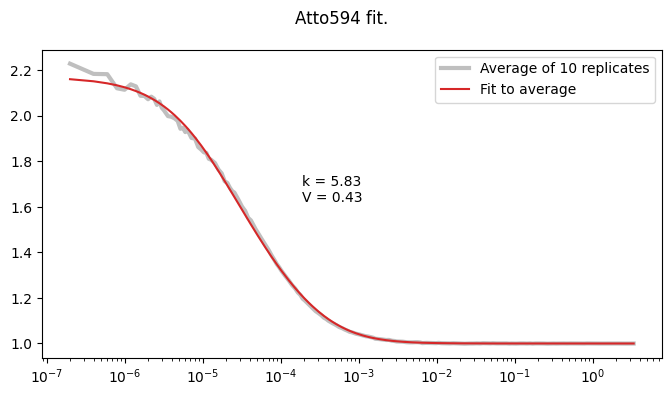

In [9]:
# Same but for red. 

# Calibrate size of focal volume using concentration of atto488
atto2nM = 'atto594_2nM.fcs'
times_corr, mean_corr, n_total = get_corr(atto2nM, dir="../data/2024_09_16-FCS/")
fit = curve_fit(f_includeK, times_corr, mean_corr, p0=None)
popt, pcov = fit
title = f"Atto594 fit."
fig, axs = plt.subplots(1, 1, figsize=(8,4))
fig.suptitle(title)
axs.set_xscale("log")
axs.plot(times_corr, mean_corr, linewidth=3, alpha=0.5, color="grey", label=f"Average of {n_total} replicates")
axs.plot(times_corr, f_includeK(times_corr, *popt), 
         label="Fit to average", color="C03")
axs.legend()
fig.text(.45,.5,s=f"k = {round(popt[2],2)} \nV = {round(popt[0]/2,2)}")
V = 0.42

mCh_ : 24.549 nM


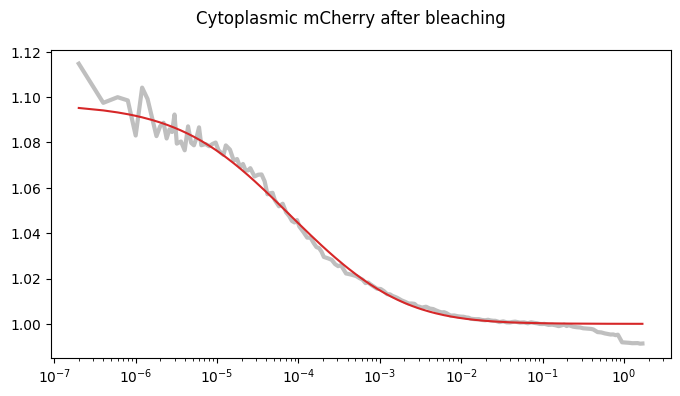

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(8,4))
title = f"Cytoplasmic mCherry after bleaching"
fig.suptitle(title)
axs.set_xscale("log")
# Red probes
mCherry = "mCh_cyt_bleached_1.fcs"
for probe in [mCherry]:
    times_corr, mean_corr, n_total = get_corr(probe, clip=135, dir="../data/2024_09_16-FCS/")
    popt, pcov = curve_fit(f_anomalous, times_corr[10:135], mean_corr[10:135], bounds=(0,100))
    counts = get_countrate(probe, dir="../data/2024_09_16-FCS/")
    N = popt[0]
    C = N/V
    print(f"{probe[:4]} : {round(C, 3)} nM")
    axs.plot(times_corr, mean_corr, linewidth=3, alpha=0.5, color="grey", label=f"Average of {n_total} replicates")
    axs.plot(times_corr, f_anomalous(times_corr, *popt), label=f"Fit of subdiffusive model \nconc = {round(C, 2)} nM", c="C03")

Ap12 : 40.695 nM
ApRa : 52.733 nM


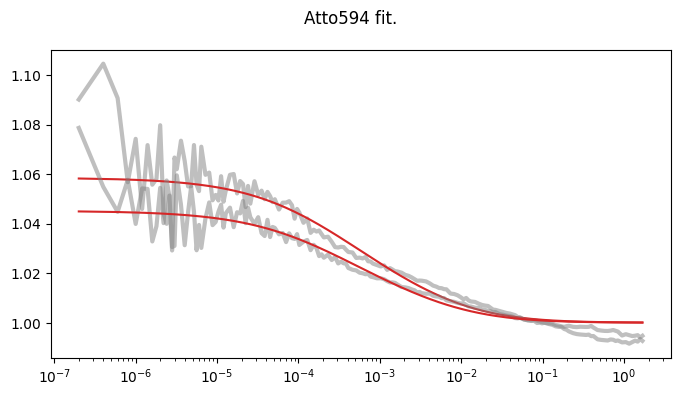

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(8,4))
fig.suptitle(title)
axs.set_xscale("log")
# Red probes
Ap12 = "Ap12_yeast.fcs"
rac1 = "ApRac1_yeast.fcs"
for probe in [Ap12, rac1]:
    times_corr, mean_corr, n_total = get_corr(probe, clip=135)
    popt, pcov = curve_fit(f_anomalous, times_corr[10:135], mean_corr[10:135], bounds=(0,100))
    counts = get_countrate(probe)
    N = popt[0]
    C = N/V
    print(f"{probe[:4]} : {round(C, 3)} nM")
    axs.plot(times_corr, mean_corr, linewidth=3, alpha=0.5, color="grey", label=f"Average of {n_total} replicates")
    axs.plot(times_corr, f_anomalous(times_corr, *popt), label=f"Fit of subdiffusive model \nconc = {round(C, 2)} nM", c="C03")